In [34]:
import cv2
import os 
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tifffile
from matplotlib import cm
import shutil
from tqdm import tqdm
from numba import njit, prange, jit

def show_PIL(image: np.array):
    im = Image.fromarray(np.uint8((lr_image[:,:,0:3]/lr_image.max())*255))
    im.show()

In [35]:
## 1. Download images from SN6 dataset:
# aws s3 cp s3://spacenet-dataset/AOIs/AOI_11_Rotterdam/ SN6_buildings/expanded --recursive

## 2. Run sctipt to split RGBNIR and PS-RGBNIR images to subimages
# python ./core/scripts/data_preparation/extract_subimages.py

In [36]:
## 3. Explore the SN6 dataset:

In [37]:
dataset_path = os.path.abspath(os.path.join(os.path.curdir, "../datasets/SN6/splitted"))
os.listdir(dataset_path)

['PS-RGBNIR', 'RGBNIR', 'test', 'train', '__PS-RGBNIR', '__RGBNIR']

In [38]:
# hr images:
hr_images_path = os.path.join(dataset_path, "PS-RGBNIR")
hr_images_list = os.listdir(hr_images_path)
print("hr image count: ", len(hr_images_list))
print(hr_images_list[0])

hr image count:  5607
0001.tif


In [39]:
# lr images:
lr_images_path = os.path.join(dataset_path, "RGBNIR")
lr_images_list = os.listdir(lr_images_path)
print("lr image count: ", len(lr_images_list))
print(lr_images_list[0])

lr image count:  5607
0001.tif


In [54]:
lr_image_path = os.path.join(lr_images_path, lr_images_list[0])
lr_image = cv2.imread(lr_image_path, cv2.IMREAD_UNCHANGED)
print("lr image shape: ", lr_image.shape)

hr_image_path = os.path.join(hr_images_path, hr_images_list[0])
hr_image = cv2.imread(hr_image_path, cv2.IMREAD_UNCHANGED)
print("hr image shape: ", hr_image.shape)

lr image shape:  (128, 128, 4)
hr image shape:  (512, 512, 4)


hr image (max, min):  1214 0
lr image (max, min):  1466 2


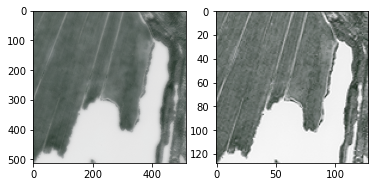

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('')
ax1.imshow(hr_image/hr_image.max())
ax2.imshow(lr_image/lr_image.max())

print("hr image (max, min): ", hr_image.max(), hr_image.min())
print("lr image (max, min): ", lr_image.max(), lr_image.min())

In [42]:
## 4. Split images into test and train and save

In [43]:
split_rate = 0.95
length = len(hr_images_list)

train_hr = hr_images_list[:int(length * 0.95)]
validation_hr = hr_images_list[int(length * 0.95):]
print("train hr image count: ", len(train_hr))
print("valid hr image count: ", len(validation_hr))

train_lr = lr_images_list[:int(length * 0.95)]
validation_lr = lr_images_list[int(length * 0.95):]
print("train lr image count: ", len(train_lr))
print("valid lr image count: ", len(validation_lr))

train hr image count:  5326
valid hr image count:  281
train lr image count:  5326
valid lr image count:  281


In [44]:
train_hr_save_path = os.path.join(dataset_path, "train/hr")
train_lr_save_path = os.path.join(dataset_path, "train/lr")
valid_hr_save_path = os.path.join(dataset_path, "test/hr")
valid_lr_save_path = os.path.join(dataset_path, "test/lr")

for folder in [train_hr_save_path, train_lr_save_path, valid_hr_save_path, valid_lr_save_path]:
    if not os.path.exists(folder):
        os.makedirs(folder)


In [45]:
def copy_images(image_name_list: list, src_dir: str, dst_dir: str):
    """ Copies all files from src directory to dst directory """
    for image_name in tqdm(image_name_list):
        image_path = os.path.join(src_dir, image_name)
        if not os.path.exists(os.path.join(dst_dir, image_name)):
            shutil.copy(image_path, dst_dir)

In [46]:
copy_images(train_hr, hr_images_path, train_hr_save_path)
copy_images(train_lr, lr_images_path, train_lr_save_path)
copy_images(validation_hr, hr_images_path, valid_hr_save_path)
copy_images(validation_lr, lr_images_path, valid_lr_save_path)

100%|██████████| 281/281 [00:02<00:00, 94.45it/s] 


In [185]:
## 5. Change config and train

In [56]:
path = "H:\Projects\SpaceSuperResolution\datasets\SN6\expanded\RGBNIR\SN6_AOI_11_Rotterdam_RGBNIR_TrainVal.tif"
im = cv2.imread(path, cv2.IMREAD_UNCHANGED)

In [58]:
print(im.shape, im.max(), im.min())
im_range = im.max() - im.min()
im = (im - im.min()) / im_range
print(im.max(), im.min())

(4051, 5700, 4) 2047 1
1.0 0.0


In [64]:
[im[:, :, i].mean() for i in range(0, im.shape[2])]

[0.08297185279312995,
 0.07921086858457316,
 0.05765653258540009,
 0.18855815818262797]

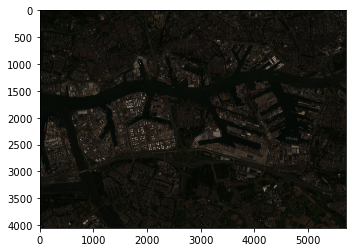

In [66]:
plt.imshow(im[:, :, 0:3])

In [67]:
for i in range(0, im.shape[2]):
    im[:, :, i] = im[:, :, i] - im[:, :, i].mean()
    print(im[:, :, i].min(), im[:, :, i].max())

-0.08297185279312995 0.9170281472068701
-0.07921086858457316 0.9207891314154268
-0.05765653258540009 0.9423434674146
-0.18855815818262797 0.811441841817372


In [ ]:
## 6. Visualization during training

In [264]:
# for hist equalizaiton
clahe = cv2.createCLAHE(clipLimit =8.0, tileGridSize=(8,8))

# show images
# visualization_dir = r"H:\Projects\SpaceSuperResolution\experiments\105_EDSR_SN6_0.46_2m_x4_pretrained\visualization\5330"
visualization_dir = r"H:\Projects\SpaceSuperResolution\experiments\105_EDSR_SN6_0.46_2m_x4_pretrained\visualization\5600"

# gt_path = os.path.join(visualization_dir, "5330_gt.tif")
# interpolated_path = os.path.join(visualization_dir, "5330_interpolated.tif")
# vis_image_names = ["5330_500.tif", "5330_1000.tif","5330_1500.tif","5330_2000.tif","5330_2500.tif", "5330_3000.tif", "5330_130000.tif"]

gt_path = os.path.join(visualization_dir, "5600_gt.tif")
interpolated_path = os.path.join(visualization_dir, "5600_interpolated.tif")
vis_image_names = ["5600_500.tif", "5600_1000.tif","5600_1500.tif","5600_2000.tif","5600_2500.tif", "5600_3000.tif", "5600_10000.tif", "5600_13000.tif"]

gt_im = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED)
interpolated_im = cv2.imread(interpolated_path, cv2.IMREAD_UNCHANGED)

images = list()
for im_name in vis_image_names:
    im_path = os.path.join(visualization_dir, im_name)
    im = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)
    for i in range(0, im.shape[2]):
        im[:, :, i] = clahe.apply(im[:, :, i])
    images.append(im)

print(len(images))

8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


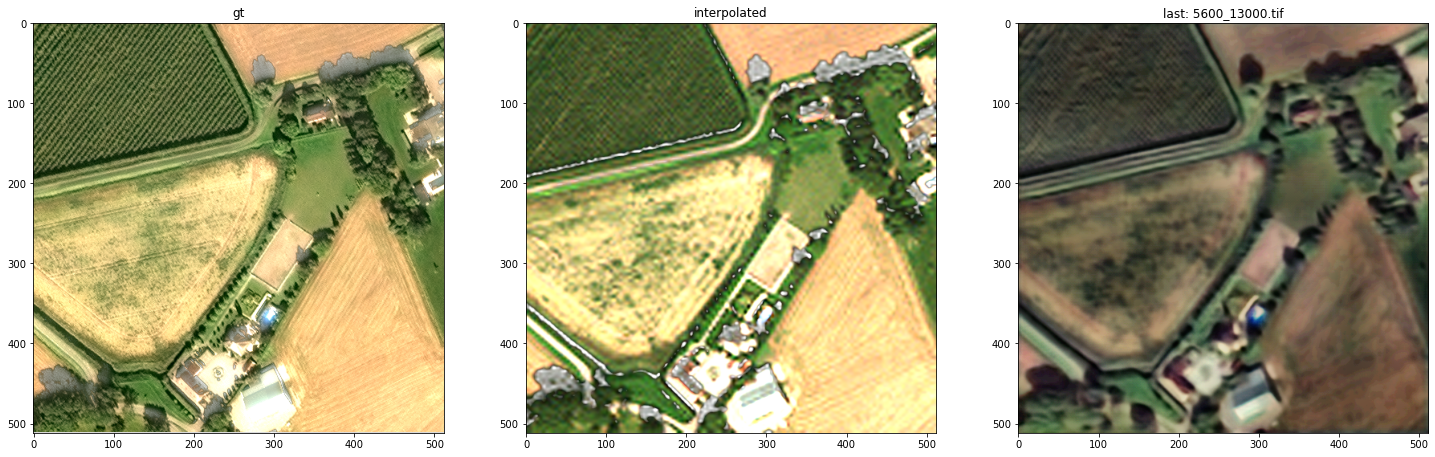

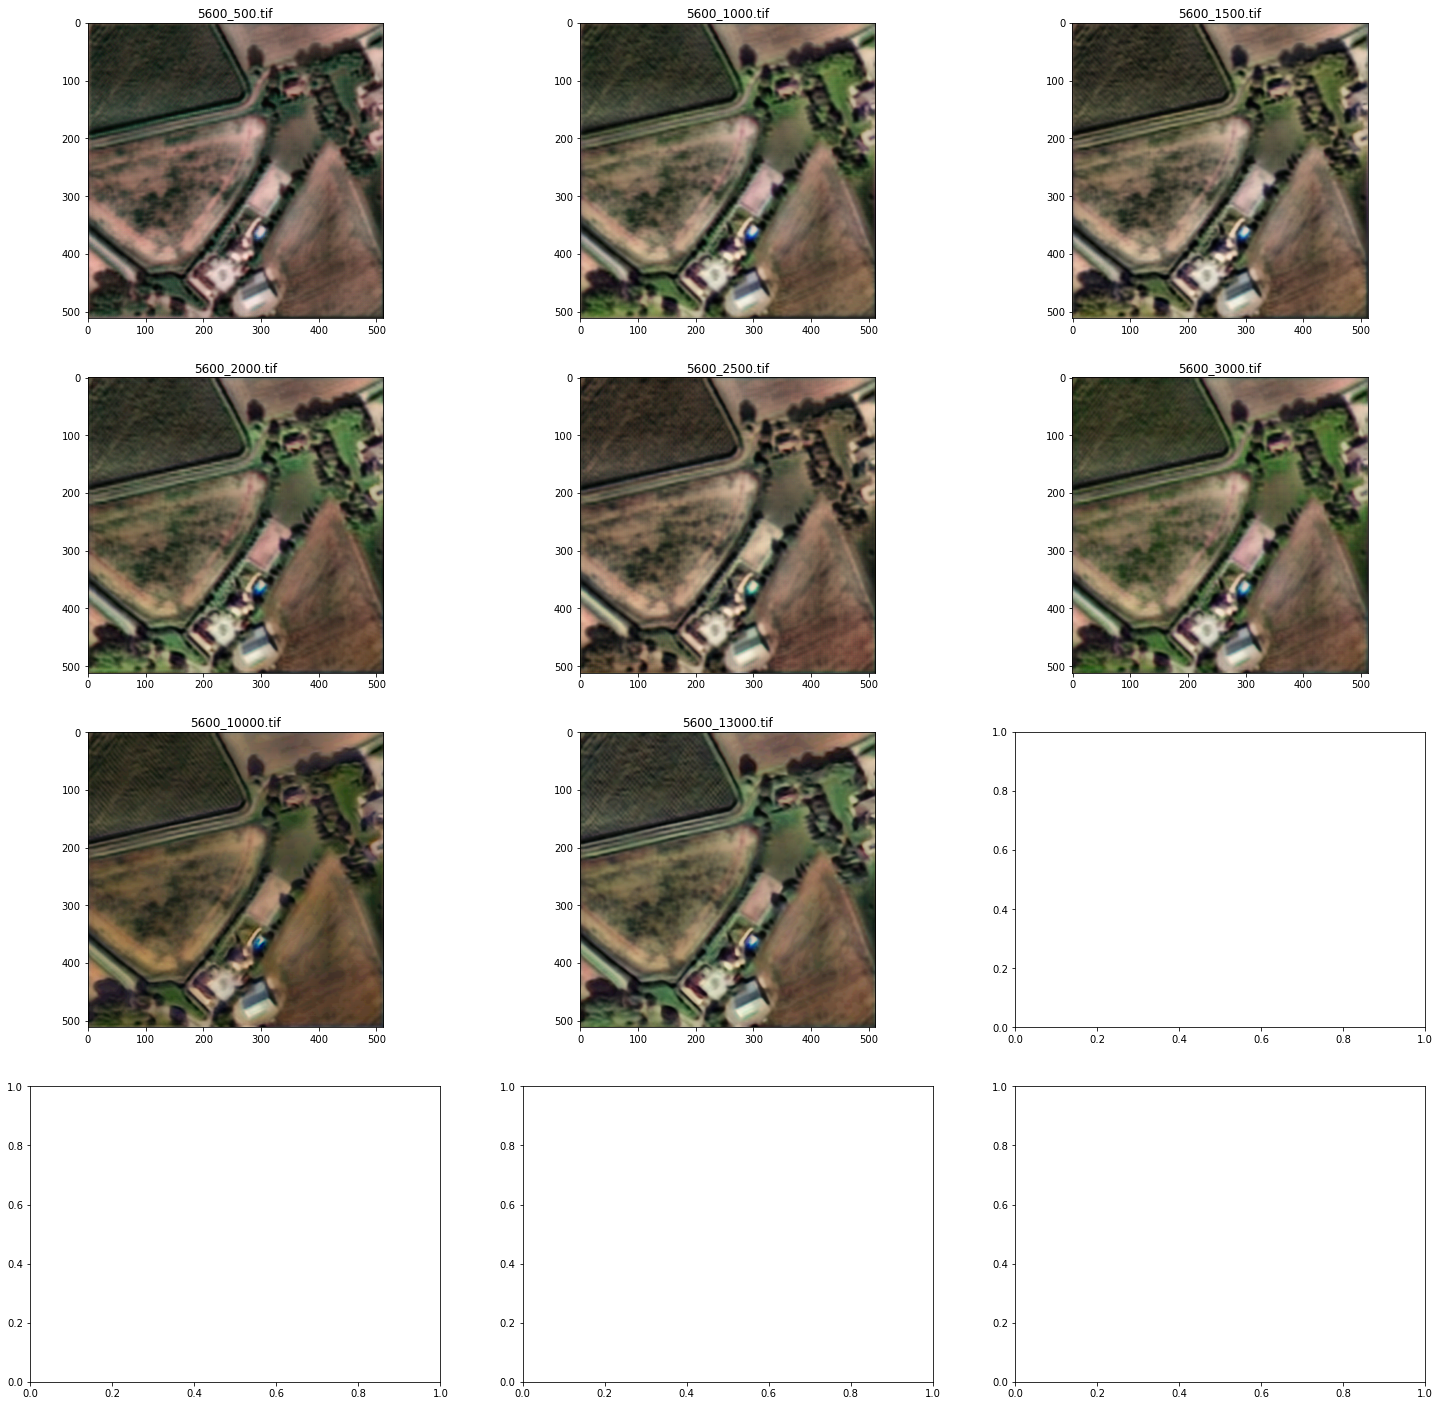

In [265]:
fig, axs = plt.subplots(1, 3, figsize=(25,25))

axs[0].imshow(gt_im)
axs[0].set_title("gt")
axs[1].imshow(interpolated_im)
axs[1].set_title("interpolated")
axs[2].imshow(images[len(images)-1][:, :, 0:3])
axs[2].set_title("last: " + vis_image_names[len(images)-1])


fig2, axs2 = plt.subplots(len(images) // 3 + 2, 3, figsize=(25,25))
for idx, image_ in enumerate(images):
    x_idx =  idx // 3   
    y_idx = idx % 3 
    axs2[x_idx, y_idx].set_title(vis_image_names[idx])
    axs2[x_idx, y_idx].imshow(image_[:, :, 0:3])

5600_13000.tif


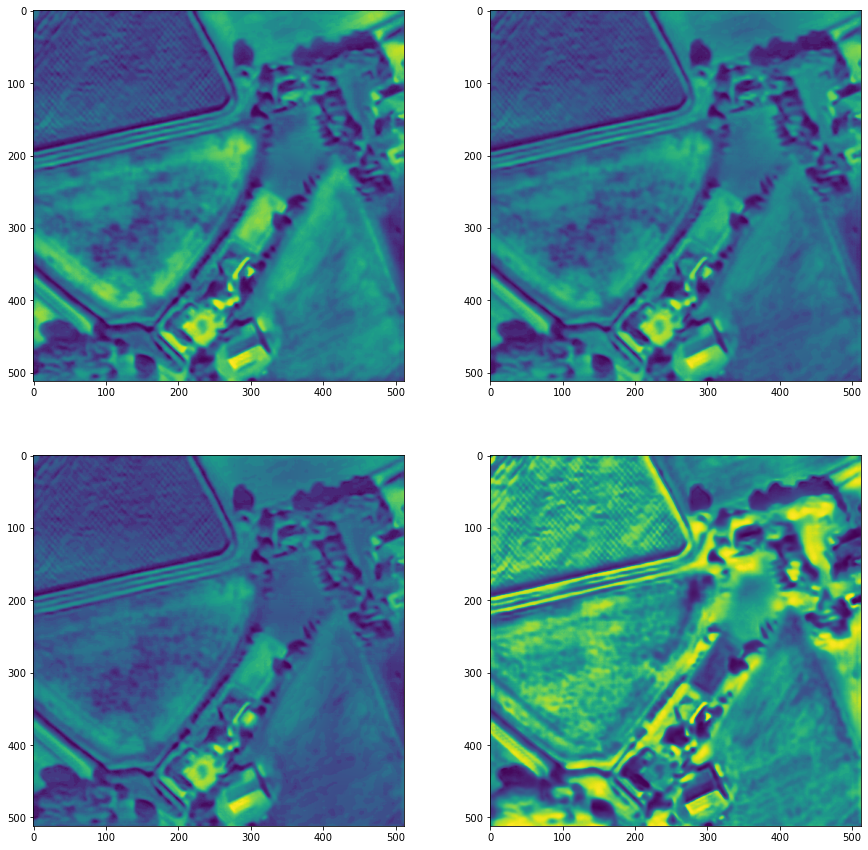

In [267]:
# Show different channels
im = images[len(images)-1]

print(vis_image_names[len(images)-1])
fig, axs = plt.subplots(2,2, figsize=(15,15))
axs[0,0].imshow(im[:, : , 0])
axs[0,1].imshow(im[:, : , 1])
axs[1,0].imshow(im[:, : , 2])
axs[1,1].imshow(im[:, : , 3])

In [281]:
# Show as Pillow image
from PIL import Image
from matplotlib import cm
im = images[len(images)-1][:,:,0:3] 
for i in range(im.shape[2]):
    # im[:,:,i] = cv2.equalizeHist(im[:,:,i])
    im[:, :, i] = clahe.apply(im[:, :, i])

im = Image.fromarray((im.astype(np.float)/gt_im.max()*255.).astype(np.uint8))
im_gt = Image.fromarray((gt_im[:,:,0:3].astype(np.float)/gt_im.max()*255.).astype(np.uint8))
im_int = Image.fromarray((interpolated_im[:,:,0:3].astype(np.float)/gt_im.max()*255.).astype(np.uint8))

In [282]:
im.show()
im_gt.show()
im_int.show()

127.22004699707031